In [183]:
from filterpy.kalman import KalmanFilter
import os
from collections import deque
from ultralytics import YOLO
import cv2
import numpy as np
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
import torch
from scipy.optimize import linear_sum_assignment

In [184]:
torch.cuda.is_available()

True

In [185]:
torch.cuda.set_device(0) # Set to your desired GPU number

In [186]:
VIDEOS_DIR = os.path.join('.', 'videos')

video_path = 'E:\\Object_Detection\\yolov8\\PredTrack\\4Vehicle_Full_LWscenario_Trim2_Dynamic_Camera.mp4'
video_path_out = '{}predTrack_tracked_out.avi'.format(video_path)

In [187]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
H, W, _ = frame.shape
out = cv2.VideoWriter(video_path_out, cv2.VideoWriter_fourcc(*'XVID'), int(cap.get(cv2.CAP_PROP_FPS)), (W, H))

In [188]:
model_path = 'E:\\Object_Detection\\yolov8\\runs\\detect\\train31\\weights\\best.pt'

# Load a model
model = YOLO(model_path)  # load a custom model

threshold = 0.5

output_frames_dir = 'Trim2_Dynamic_Camera_Frames_PredTrack'
os.makedirs(output_frames_dir, exist_ok=True)
labels_dir = 'labels'  # Define your labels directory
os.makedirs(labels_dir, exist_ok=True)

In [189]:
# Define colors for different classes
COLORS = {
    0: (255, 0, 0),    # Class 0: Blue
    1: (0, 255, 0),    # Class 1: Green
    2: (0, 0, 255),    # Class 2: Red
    3: (255, 255, 0),  # Class 3: Cyan
    4: (255, 0, 128),  #Class 4: Orange
}

CLASS = {
    0: "Four-legged Animal",
    1: "Military Vehicle",
    2: "Tank",
    3: "Car",
    4: "Person",
}

# Font settings
font_scale = 0.6
font_thickness = 2

frame_id=0

history=[]

In [190]:
fps = cap.get(cv2.CAP_PROP_FPS)
dt = 1/fps 

In [191]:
# Initialize Kalman Filter using filterpy
def create_kalman_filter():
    kf = KalmanFilter(dim_x=8, dim_z=4)
    #State transition matrix
    kf.F = np.array([[1, 0, 0, 0, dt, 0, 0, 0],
                     [0, 1, 0, 0, 0, dt, 0, 0],
                     [0, 0, 1, 0, 0, 0, dt, 0],
                     [0, 0, 0, 1, 0, 0, 0, dt],
                     [0, 0, 0, 0, 1, 0, 0, 0],  
                     [0, 0, 0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 0, 0, 1]])
    
    # Measurement function (H): maps the 8D state vector to the 4D measurement (u, v, h, w)
    kf.H = np.array([[1, 0, 0, 0, 0, 0, 0, 0],  # measure u (center_x)
                     [0, 1, 0, 0, 0, 0, 0, 0],  # measure v (center_y)
                     [0, 0, 1, 0, 0, 0, 0, 0],  # measure w (width)
                     [0, 0, 0, 1, 0, 0, 0, 0]], np.float32)  # measure h (height)

    kf.P = np.eye(8)  # Covariance matrix
    kf.R = np.array([[1, 0, 0, 0],  # Measurement noise for u (position)
                     [0, 1, 0, 0],  # Measurement noise for v (position)
                     [0, 0, 1, 0],  # Measurement noise for h (size)
                     [0, 0, 0, 1]], np.float32) * 1e-5
    kf.Q = np.eye(8) * 1e-5
    # Initial state estimate
    kf.x = np.zeros((8, 1))
    return kf

In [192]:
kalman_filters = {}
object_ids = {}
kalman_filters_class = {}
alpha={}
beta_high=0.5
beta_low=0.6
gamma = 0.49
cov_matrix_factor=1/200
p1=0.6
p2=0.4

In [193]:
# IoU calculation function
def calculate_iou(boxA, boxB):
    # Convert [x, y, w, h] to [x1, y1, x2, y2] for both Box A and Box B
    x1A, y1A = boxA[0] - boxA[2] / 2, boxA[1] - boxA[3] / 2  # Box A (x1, y1)
    x2A, y2A = boxA[0] + boxA[2] / 2, boxA[1] + boxA[3] / 2  # Box A (x2, y2)
    
    x1B, y1B = boxB[0] - boxB[2] / 2, boxB[1] - boxB[3] / 2  # Box B (x1, y1)
    x2B, y2B = boxB[0] + boxB[2] / 2, boxB[1] + boxB[3] / 2  # Box B (x2, y2)
    
    # Compute the coordinates of the intersection rectangle
    xA = max(x1A, x1B)
    yA = max(y1A, y1B)
    xB = min(x2A, x2B)
    yB = min(y2A, y2B)

    # Compute the area of the intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both bounding boxes
    boxAArea = (x2A - x1A) * (y2A - y1A)
    boxBArea = (x2B - x1B) * (y2B - y1B)

    # Compute the IoU by dividing the intersection area by the union area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou


In [194]:
def calculate_mahalanobis(boxA, boxB):
    """
    Calculates the Mahalanobis distance between two bounding boxes.

    Parameters:
    boxA: List of [x, y, w, h] for the first bounding box
    boxB: List of [xp, yp, wp, hp] for the second bounding box

    Returns:
    Mahalanobis distance between boxA and boxB
    """
    # Convert the bounding boxes to numpy arrays
    boxA = np.array(boxA)
    boxB = np.array(boxB)
    
    # Calculate the difference (x - μ)
    diff = boxA - boxB
    diff = diff.reshape(-1, 1)  # Reshape diff to column vector
    
    for i, kf in kalman_filters.items():
        if kf is not None:
            if kf.x is not None:
                xp1, yp1, wp1, hp1 = kf.x[0, 0], kf.x[1, 0], kf.x[2, 0], kf.x[3, 0]
                if np.allclose([xp1, yp1, wp1, hp1], boxB, atol=1e-5):
                    # Calculate S
                    S = kf.H @ kf.P @ kf.H.T + kf.R
                    S += np.eye(S.shape[0]) * 1e-6  # Stabilize S for inversion
                    try:
                        S_inv = np.linalg.inv(S)
                        # Calculate Mahalanobis distance
                        mahalanobis_distance = np.sqrt(np.dot(np.dot(diff.T, S_inv), diff))
                        return np.sqrt(mahalanobis_distance)
                    except np.linalg.LinAlgError:
                        print("Covariance matrix S is singular and cannot be inverted.")
                        return float('inf')  # Return a large distance if S is singular
    
    print("No matching Kalman filter found for the predicted bounding box.")
    return float('inf')


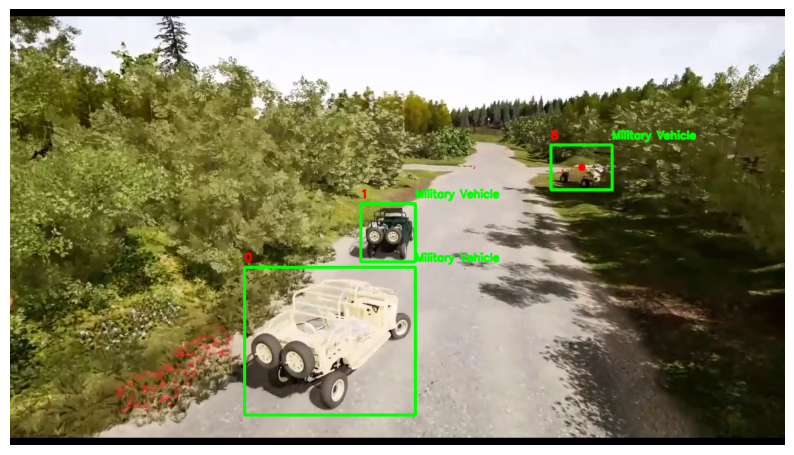

In [195]:

while ret:
    print("frame_id: ", frame_id)
    results = model(frame)[0]
    detections = []
    detections_high = []
    detections_low = []
    track = {}
    track_predicted = {}
    predicted = []
    unmatched = []
    
    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result
        x_mean = (x1 + x2) / 2
        y_mean = (y1 + y2) / 2
        width = abs(x2 - x1)
        height = abs(y2 - y1)
        detections.append((x_mean, y_mean, class_id, width, height))
        detections_low.append((x_mean, y_mean, class_id, width, height))

        if score >= threshold:
            #color = COLORS.get(int(class_id), (0, 255, 0))  # Default to green if class_id is not in COLORS
            #cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 4)
            #cv2.putText(frame, results.names[int(class_id)].upper(), (int(x1), int(y1 - 10)),
            #    cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, font_thickness, cv2.LINE_AA)
            detections_high.append((x_mean, y_mean, class_id, width, height))
            detections_low.remove((x_mean, y_mean, class_id, width, height))
            
    #print("detection_high: ", detections_high)
    #print("detection_low: ", detections_low)

    #print("kalman filters: ", kalman_filters)
    if frame_id == 0:
        for i, (x, y, class_id, w, h) in enumerate(detections_high):
            kalman_filters[i] = create_kalman_filter()
            kalman_filters[i].update(np.array([x, y, w, h], np.float32).reshape(4, 1))
            kalman_filters_class[i] = class_id
            alpha[i] = 0.5
            track_predicted[i] = (x, y, w, h)
            track[i] = (x, y, w, h)
    else:
        # Prediction and update
        # Assuming you want to fill track_predicted with None for indices not in kalman_filters
        for j in range(len(kalman_filters)):  # Ensure the range covers the max index
            kf = kalman_filters[j]
            if kf is not None:
                prediction = kf.predict()
                if kf.x is not None:
                    xp, yp, wp, hp = kf.x[0,0], kf.x[1,0], kf.x[2,0], kf.x[3,0]
                    predicted.append((xp, yp, wp, hp))
                    track_predicted[j] = (xp, yp, wp, hp)
            else:
                track_predicted[j] = None  # Set to None if the Kalman filter does not exist
        #print("tracks with track_ids: ", track_predicted)
        # Construct the cost matrix
        num_tracks = len(track_predicted)
        num_detections = len(detections)

        cost_matrix = np.full((num_tracks, num_detections), 1e6)
        #print("cost matrix: ", cost_matrix)
        #print("detection_high calculation here")
        new_detections = []
        for i, track_data in track_predicted.items():
            if track_data is not None:
                xp, yp, wp, hp = track_data
                for j, (x, y, class_id, w, h) in enumerate(detections):
                    if (x, y, class_id, w, h) in detections_high:
                        similarity_IOU = calculate_iou([x, y, w, h], [xp, yp, wp, hp])
                        #print(f"similarity IOU for ({x, y, w, h}) and ({xp, yp, wp, hp}) is: ", similarity_IOU)
                        similarity_mahalanobis =1-cov_matrix_factor*calculate_mahalanobis([x, y, w, h], [xp, yp, wp, hp])
                        #print(f"similarity mahalanobis for ({x, y, w, h}) and ({xp, yp, wp, hp}) is: ", similarity_mahalanobis)
                        cost_matrix[i, j] = 1 - (similarity_IOU + similarity_mahalanobis) / 2
                        #print(f"cost for ({x, y, w, h}) and ({xp, yp, wp, hp}) is: ", cost_matrix[i,j])

        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        #print("row_ind after matched with detection_high: ", row_ind)
        #print("col_ind after matched with detection_high: ", col_ind)

        matched_detections_high = set()
        for row, col in zip(row_ind, col_ind):
            #print(f"cost matrix of row {row}, col {col} is: ", cost_matrix[row, col])
            if cost_matrix[row, col] < beta_high:  # Use a threshold to filter out poor matches
                track_id = row
                detection = detections[col]
                #print(f"track id for {[detection[0], detection[1], detection[3], detection[4]]} is : ", track_id)
                kalman_filters[track_id].update(np.array([detection[0], detection[1], detection[3], detection[4]], np.float32).reshape(4, 1))
                track[track_id] = (detection[0], detection[1], detection[3], detection[4])
                kalman_filters_class[track_id] = detection[2]
                if alpha[track_id]<1:
                    alpha[track_id] += 0.5
                matched_detections_high.add(col)
        
        # Create `unmatched` list by comparing `track_predicted` and `track`
        unmatched = [
            track_predicted[track_id]
            for track_id in track_predicted
            if track_id not in track
        ]

        #print("unmatched: ", unmatched)


        # Convert `track` values to a set for easier comparison
        track_set = set((x_track, y_track, w_track, h_track) for x_track, y_track, w_track, h_track in track.values())

        # Initialize new_detections by filtering out any detection that already matches a track
        new_detections = [detection for detection in detections_high if (detection[0], detection[1], detection[3], detection[4]) not in track_set]

        # Output the new_detections
        #print("new_detections: ", new_detections)

        # Iterate over each detection in detections_low
        for j, (x, y, class_id, w, h) in enumerate(detections):
            if (x, y, class_id, w, h) in detections_low:
                if unmatched:  # Check if there are unmatched tracks
                    for i, track_data in enumerate(unmatched):
                        if track_data is not None:
                            xp, yp, wp, hp = track_data
                            # Get the corresponding track_id from track_predicted keys
                            track_id = next((key for key, value in track_predicted.items() if value == (xp, yp, wp, hp)), None)
                            #print("track id: ", track_id)
                
                            # Calculate IOU and Mahalanobis similarity
                            similarity_IOU = calculate_iou([x, y, w, h], [xp, yp, wp, hp])
                            #print(f"similarity IOU for ({x, y, w, h}) and ({xp, yp, wp, hp}) is: ", similarity_IOU)
                
                            similarity_mahalanobis = 1 - cov_matrix_factor * calculate_mahalanobis([x, y, w, h], [xp, yp, wp, hp])
                            #print(f"similarity Mahalanobis for ({x, y, w, h}) and ({xp, yp, wp, hp}) is: ", similarity_mahalanobis)
                
                            # Update the cost matrix for this unmatched track and detection
                            cost_matrix[track_id, j] = 1 - 2*alpha[track_id] * (p1*similarity_IOU + p2*similarity_mahalanobis)
                            #print(f"cost for ({x, y, w, h}) and ({xp, yp, wp, hp}) is: ", cost_matrix[track_id, j])


        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        #print("row_ind after matched with detection_low: ", row_ind)
        #print("col_ind after matched with detection_low: ", col_ind)
        
        matched_detections_low = set()
        for row, col in zip(row_ind, col_ind):
            #print(f"cost of row={row} and col={col} in detection_low matching: ", cost_matrix[row, col])
            if cost_matrix[row, col] < beta_low:  # Use a threshold to filter out poor matches
                track_id = row
                detection = detections[col]
                #print(f"track id for {[detection[0], detection[1], detection[3], detection[4]]} is : ", track_id)
                kalman_filters[track_id].update(np.array([detection[0], detection[1], detection[3], detection[4]], np.float32).reshape(4, 1))
                track[track_id]=detection[0], detection[1], detection[3], detection[4]
                if alpha[track_id]<1:
                    alpha[track_id] += 0.25
                matched_detections_low.add(col)

        remaining_unmatched_tracks = [
            track_predicted[track_id]
            for track_id in track_predicted
            if track_id not in track
        ]

        #print("remaining_unmatched_tracks in this way: ", remaining_unmatched_tracks)
        # remaining_unmatched_track_ids = [unmatched[i] for i in range(len(unmatched)) if i not in matched_detections_low]
        # print("remaining_unmatched_track_ids: ", remaining_unmatched_track_ids)
        
        for p, track_data in enumerate(remaining_unmatched_tracks):
            for i, predicted_track in track_predicted.items():
                if track_data == predicted_track:
                    track_id=i
                    if alpha[track_id]>0:
                        alpha[track_id] -=0.05
                    #print(f"alpha[{track_id}]: ", alpha[track_id])
                    if alpha[track_id]>gamma:
                        x_pred, y_pred, w_pred, h_pred = predicted_track
                        cv2.circle(frame, (int(x_pred), int(y_pred)), 6, (0, 0, 255), -1)
                        class_id = kalman_filters_class[track_id]
                        track[track_id]=(x_pred, y_pred, w_pred, h_pred)
                        x1_pred=x_pred-w_pred/2
                        x2_pred=x_pred+w_pred/2
                        y1_pred=y_pred-h_pred/2
                        y2_pred=y_pred+h_pred/2
                        cv2.rectangle(frame, (int(x1_pred), int(y1_pred)), (int(x2_pred), int(y2_pred)), (203, 192, 255), 4)
                        cv2.putText(frame, str(track_id), (int(x1_pred), int(y1_pred-10)),
                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 255), font_thickness, cv2.LINE_AA)
                        cv2.putText(frame, CLASS[class_id], (int(x2_pred), int(y1_pred - 10)),
                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, COLORS.get(int(class_id)), font_thickness, cv2.LINE_AA)                    
                    if alpha[track_id]<0.1:
                        kalman_filters[track_id] = None

        #print("length of track: ", len(track))
        for i, [x,y,class_id, w, h] in enumerate(new_detections):
            #print("i= ",i)
            new_track_id=len(track_predicted)+i
            #print("new_track_id: ", new_track_id)
            kalman_filters[new_track_id] = create_kalman_filter()
            kalman_filters[new_track_id].update(np.array([x, y, w, h], np.float32).reshape(4, 1))
            kalman_filters_class[new_track_id] = class_id
            alpha[new_track_id] = 0.5
            track[new_track_id] = (x, y, w, h)
            #print(f"new detection with track id {new_track_id}: ",(x, y, w, h) )

    #print("track: ", track)
    for i, item in track.items():
        if item is not None:
            x, y, w, h = item
            class_id=kalman_filters_class[i]
            color = COLORS.get(int(class_id), (0, 255, 0))
            x1=x-w/2
            x2=x+w/2
            y1=y-h/2
            y2=y+h/2
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)),color, 4)
            cv2.putText(frame, str(i), (int(x1), int(y1-10)),
                cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 255), font_thickness, cv2.LINE_AA)
            cv2.putText(frame, CLASS[class_id], (int(x2), int(y1 - 10)),
                cv2.FONT_HERSHEY_SIMPLEX, font_scale, COLORS.get(int(class_id)), font_thickness, cv2.LINE_AA)
            
    label_file_path = os.path.join(labels_dir, f'frame{frame_id}.txt')
    with open(label_file_path, 'w') as label_file:
        for i, item in track.items():
            if item is not None:
                x, y, w, h = item
                class_id=kalman_filters_class[i]
                # Normalize the coordinates and dimensions
                norm_x = x / frame.shape[1]  # Normalize x_center
                norm_y = y / frame.shape[0]  # Normalize y_center
                norm_width = w / frame.shape[1]  # Normalize width
                norm_height = h / frame.shape[0]  # Normalize height
            
                # Write to label file in the format: class_id x_center y_center width height
                label_file.write(f"{int(i)} {int(class_id)} {norm_x:.6f} {norm_y:.6f} {norm_width:.6f} {norm_height:.6f}\n")

        
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    clear_output(wait=True)

    plt.figure(figsize=(10, 8))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()

    # Save each frame as an image
    frame_filename = os.path.join(output_frames_dir, f'frame{frame_id}.jpg')
    cv2.imwrite(frame_filename, frame)
    out.write(frame)
    ret, frame = cap.read()
    frame_id+=1
    # previous_object=object_ids.copy()
    # previous_objects.appendleft(previous_object)
    # print("previous_objects: ",previous_objects)
  
cap.release()
out.release()


    



                

            
